In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Код использует преобразования PyTorch для определения простых преобразований изображений.Compose. Он нормализует и преобразует фотографии в тензоры.

In [47]:
# Define a basic transform
transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


Загрузка набора данных
CIFAR-10 создается для обучения с помощью приведенного ниже кода, который также определяет корневой каталог, включает режим обучения, загружает при необходимости и применяет указанное преобразование. Впоследствии она генерирует 32-пакетный загрузчик данных и перетасовывает обучающий набор данных.




In [48]:
train_dataset = datasets.CIFAR10(root='./data',\
			train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, \
								batch_size=32, shuffle=True)


100%|██████████| 170498071/170498071 [00:01<00:00, 95745896.77it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


Определение параметров, которые будут использоваться в последующих процессах
Генеративная состязательная сеть (GAN) используется с заданными гиперпараметрами.

Размерность скрытого пространства представлена символом latent_dim.
lr - это скорость обучения, заданная оптимизатором.
Коэффициенты для оптимизатора Adam равны beta1 и beta2. Чтобы определить общее количество эпох обучения, используйте num_epochs.

In [49]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 10


Определение служебного класса для создания генератора
Архитектура генератора для GAN в PyTorch определена с помощью приведенного ниже кода.

От nn.Модуль, наследующий класс Generator. Она состоит из последовательной модели со слоями Tanh, линейной, сверточной, пакетной нормализации, изменения формы и повышения дискретизации.
Нейронная сеть синтезирует изображение (img) из скрытого вектора (z), который является выходным сигналом генератора.
Архитектура использует серию изученных преобразований, чтобы превратить исходный случайный шум в скрытом пространстве в осмысленное изображение.

In [50]:
# Define the generator
class Generator(nn.Module):
	def __init__(self, latent_dim):
		super(Generator, self).__init__()

		self.model = nn.Sequential(
			nn.Linear(latent_dim, 128 * 8 * 8),
			nn.ReLU(),
			nn.Unflatten(1, (128, 8, 8)),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 128, kernel_size=3, padding=1),
			nn.BatchNorm2d(128, momentum=0.78),
			nn.ReLU(),
			nn.Upsample(scale_factor=2),
			nn.Conv2d(128, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64, momentum=0.78),
			nn.ReLU(),
			nn.Conv2d(64, 3, kernel_size=3, padding=1),
			nn.Tanh()
		)

	def forward(self, z):
		img = self.model(z)
		return img


Определение служебного класса для построения дискриминатора
Код PyTorch описывает архитектуру дискриминатора для GAN. Дискриминатор класса происходит от nn.Module. Она состоит из линейных слоев, пакетной нормализации, отсева, сверточной, LeakyReLU и последовательных слоев.

Изображение (img) является входным сигналом дискриминатора, а его достоверность — вероятность того, что входное изображение является реальным, в отличие от искусственного, - является его выходным сигналом.

In [51]:
# Define the discriminator
class Discriminator(nn.Module):
	def __init__(self):
		super(Discriminator, self).__init__()

		self.model = nn.Sequential(
		nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
		nn.ZeroPad2d((0, 1, 0, 1)),
		nn.BatchNorm2d(64, momentum=0.82),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
		nn.BatchNorm2d(128, momentum=0.82),
		nn.LeakyReLU(0.2),
		nn.Dropout(0.25),
		nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
		nn.BatchNorm2d(256, momentum=0.8),
		nn.LeakyReLU(0.25),
		nn.Dropout(0.25),
		nn.Flatten(),
		nn.Linear(256 * 5 * 5, 1),
		nn.Sigmoid()
	)

	def forward(self, img):
		validity = self.model(img)
		return validity


Построение генеративной состязательной сети
Фрагмент кода определяет и инициализирует дискриминатор (Discriminator) и генератор (Generator).

Указанное устройство (графический процессор, если имеется) поддерживает обе модели. Потеря двоичной перекрестной энтропии, которая часто используется для GAN, выбирается в качестве функции потерь (adversarial_loss).
Для генератора (optimizer_G) и дискриминатора (optimizer_D) также определены отдельные оптимизаторы Adam с заранее заданными скоростями обучения и бета-версиями.

In [53]:
# Define the generator and discriminator
# Initialize generator and discriminator
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
# Loss function
adversarial_loss = nn.BCELoss()
# Optimizers
optimizer_G = optim.Adam(generator.parameters()\
						, lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters()\
						, lr=lr, betas=(beta1, beta2))


Обучение генеративной состязательной сети
Для генеративной состязательной сети (GAN) код реализует цикл обучения.

Пакеты обучающих данных повторяются в течение каждой эпохи. В то время как генератор (optimizer_G) обучен генерировать реалистичные изображения, которые обманывают дискриминатор, дискриминатор (optimizer_D) обучен различать реальные изображения от поддельных.
Вычисляются потери генератора и дискриминатора от состязательности. Параметры модели обновляются с помощью оптимизаторов Adam, и потери распространяются в обратном направлении.
Печать дискриминатора и потери генератора используются для отслеживания прогресса. Для визуальной оценки процесса обучения сгенерированные изображения дополнительно сохраняются и показываются каждые 10 эпох.


Epoch [1/10]						Batch 100/1563 Discriminator Loss: 0.7354 Generator Loss: 1.2904
Epoch [1/10]						Batch 200/1563 Discriminator Loss: 0.6199 Generator Loss: 1.1949
Epoch [1/10]						Batch 300/1563 Discriminator Loss: 0.6844 Generator Loss: 1.1040
Epoch [1/10]						Batch 400/1563 Discriminator Loss: 0.5944 Generator Loss: 0.9284
Epoch [1/10]						Batch 500/1563 Discriminator Loss: 0.4985 Generator Loss: 1.1864
Epoch [1/10]						Batch 600/1563 Discriminator Loss: 0.6057 Generator Loss: 1.1763
Epoch [1/10]						Batch 700/1563 Discriminator Loss: 0.5083 Generator Loss: 1.3935
Epoch [1/10]						Batch 800/1563 Discriminator Loss: 0.5931 Generator Loss: 0.9285
Epoch [1/10]						Batch 900/1563 Discriminator Loss: 0.7565 Generator Loss: 0.8572
Epoch [1/10]						Batch 1000/1563 Discriminator Loss: 0.8276 Generator Loss: 0.7635
Epoch [1/10]						Batch 1100/1563 Discriminator Loss: 0.7077 Generator Loss: 1.0893
Epoch [1/10]						Batch 1200/1563 Discriminator Loss: 0.6694 Generator Loss: 0.9198
E

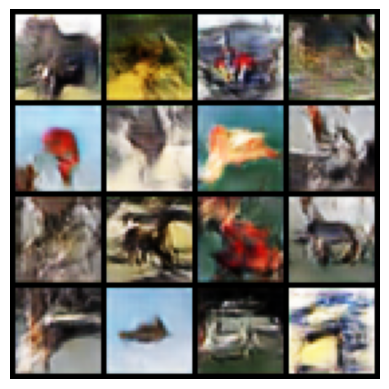

In [54]:
# Training loop
for epoch in range(num_epochs):
	for i, batch in enumerate(dataloader):
	# Convert list to tensor
		real_images = batch[0].to(device)
		# Adversarial ground truths
		valid = torch.ones(real_images.size(0), 1, device=device)
		fake = torch.zeros(real_images.size(0), 1, device=device)
		# Configure input
		real_images = real_images.to(device)

		# ---------------------
		# Train Discriminator
		# ---------------------
		optimizer_D.zero_grad()
		# Sample noise as generator input
		z = torch.randn(real_images.size(0), latent_dim, device=device)
		# Generate a batch of images
		fake_images = generator(z)

		# Measure discriminator's ability
		# to classify real and fake images
		real_loss = adversarial_loss(discriminator\
									(real_images), valid)
		fake_loss = adversarial_loss(discriminator\
									(fake_images.detach()), fake)
		d_loss = (real_loss + fake_loss) / 2
		# Backward pass and optimize
		d_loss.backward()
		optimizer_D.step()

		# -----------------
		# Train Generator
		# -----------------

		optimizer_G.zero_grad()
		# Generate a batch of images
		gen_images = generator(z)
		# Adversarial loss
		g_loss = adversarial_loss(discriminator(gen_images), valid)
		# Backward pass and optimize
		g_loss.backward()
		optimizer_G.step()
		# ---------------------
		# Progress Monitoring
		# ---------------------
		if (i + 1) % 100 == 0:
			print(
				f"Epoch [{epoch+1}/{num_epochs}]\
						Batch {i+1}/{len(dataloader)} "
				f"Discriminator Loss: {d_loss.item():.4f} "
				f"Generator Loss: {g_loss.item():.4f}"
			)
	# Save generated images for every epoch
	if (epoch + 1) % 10 == 0:
		with torch.no_grad():
			z = torch.randn(16, latent_dim, device=device)
			generated = generator(z).detach().cpu()
			grid = torchvision.utils.make_grid(generated,\
										nrow=4, normalize=True)
			plt.imshow(np.transpose(grid, (1, 2, 0)))
			plt.axis("off")
			plt.show()



Модель искусственного интеллекта, известная как GAN, состоит из двух нейронных сетей — дискриминатора и генератора, — которые были разработаны в тандеме с использованием состязательного обучения. Дискриминатор оценивает новые экземпляры данных на предмет подлинности, в то время как генератор создает новые.


GAN могут выдавать высококачественные фотореалистичные результаты при синтезе изображений, видео, музыки и в других задачах.
Обучение без учителя: GAN можно обучать без помеченных данных, что делает их подходящими для задач обучения без учителя, где помеченных данных мало или их трудно получить.

Универсальность: GAN могут применяться для широкого круга задач, включая синтез изображений, преобразование текста в изображение, преобразование изображения в изображение, обнаружение аномалий, увеличение данных и другие.

Из недостатков:
GAN могут быть сложными в обучении с риском нестабильности, сбоя режима или невозможности конвергенции;
GAN могут требовать много вычислительных ресурсов и могут быть медленными в обучении, особенно для изображений с высоким разрешением или больших наборов данных и др.

Качество, разнообразие и сходство полученных выборок с реальными данными являются основными критериями, используемыми для оценки GAN. Для количественной оценки часто используются такие показатели, как начальная дистанция Фреше (FID) и начальный балл.

При обучении GAN мы не хотим, чтобы какая-то из сторон победила. Если победит дискриминатор, то есть он идеально отличает сгенерированные картинки от настоящих, то это значит, что мы плохо генерируем. Если победит генератор, то есть дискриминатор всегда говорит, что картинки настоящие, то толку от такого дискриминатора нет, обучение не идёт. Поэтому стараются сделать так, чтобы они какое-то время соревновались на равных.